# Sequence to Sequence and Attention Mechanism

In this code we'll we will dig much deeper and try and come up with the model ourselves. We will see the steps required to do so. 

For the actual model refer to [this](https://colab.research.google.com/drive/1yyQw39zVJOHtJSivjJICR4AlH4U8JwQf?usp=sharing) colab link. 

The part we are going to borrow from the code above is the data-preprocessing as that is straight forward. 

In [5]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-07-24 17:39:42--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.37, 99.86.37.116, 99.86.37.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.8MB/s    in 0.2s    

2021-07-24 17:39:42 (17.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis tres interesse par le poste .', 'i m very interested in the job .']


In [13]:
sample = random.choice(pairs)
sample

['elles sont tres grosses .', 'they are very big .']

In [14]:
input_sentence = sample[0]
target_sentence = sample[1]

input_lang.word2index['entetee']

1344

In [15]:
input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]
input_indices, target_indices

([351, 349, 121, 1062, 5], [221, 124, 303, 131, 4])

In [16]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)
input_indices, target_indices

([351, 349, 121, 1062, 5, 1], [221, 124, 303, 131, 4, 1])

In [17]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)

In [18]:
input_tensor.shape, input_tensor.view(-1, 1).shape

(torch.Size([6]), torch.Size([6, 1]))

## Initialize Encoder Model
---

In [39]:
input_size = input_lang.n_words
num_layers = 1
hidden_size = 256

In [40]:
embedding = nn.Embedding(input_size, hidden_size).to(device)
lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bias=False).to(device)

#### Initialize variables

In [41]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
encoder_hidden = torch.zeros(1, 1, 256, device=device)
encoder_cell_state = torch.zeros(1, 1, 256, device=device)

## Encoder Model Training
---

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_matrix(encoder_outputs):
  enc_op = encoder_outputs.detach().cpu().numpy()
  fig, ax = plt.subplots(figsize=(15,8)) 
  sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=False, cmap="YlGnBu", ax=ax)
  plt.title('Encoder Output', fontsize = 20) # title with fontsize 20
  plt.xlabel('Hidden state', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('Token', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

When 'elles' is passed to the encoder:


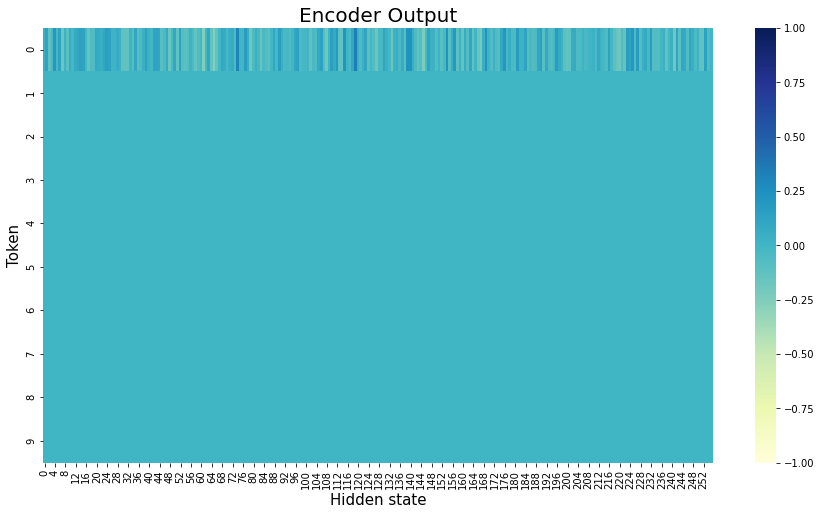

In [43]:
i = 0

print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
# input_tensor - 1st word/token is taken from input sentence. It is then reshaped to add batch dimension and passed to the embedding layer.
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
# output of embedding layer is passed into LSTM Layer
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# print(encoder_outputs.shape, encoder_hidden.shape)
# View of Encoder Ouput
plot_matrix(encoder_outputs)

When 'sont' is passed to the encoder:


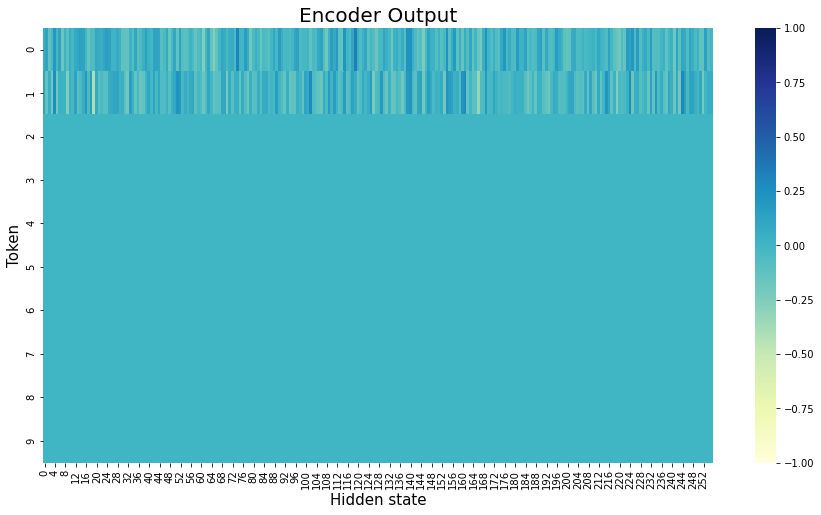

In [44]:
i = 1

print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
# input_tensor - 2nd word/token is taken from input sentence. It is then reshaped to add batch dimension and passed to the embedding layer.
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
# output of embedding layer is passed into LSTM Layer
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# View of Encoder Ouput
plot_matrix(encoder_outputs)

When 'tres' is passed to the encoder:


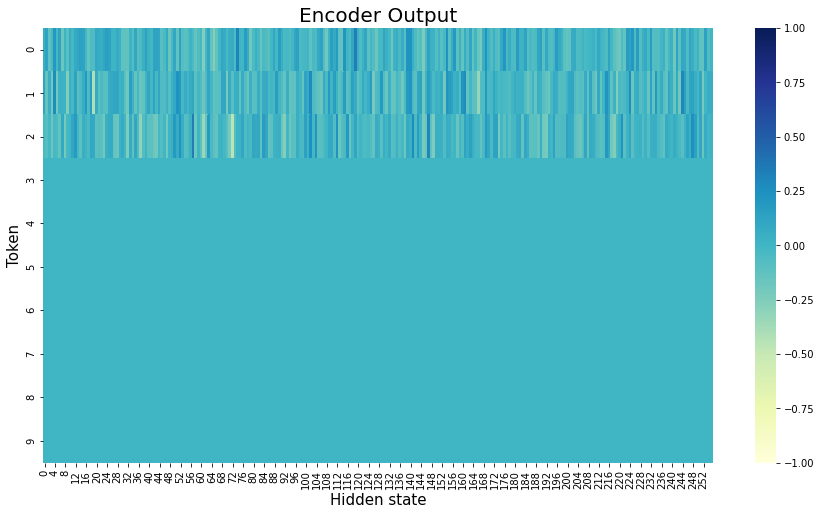

In [45]:
i = 2

print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# print(encoder_outputs.shape, encoder_hidden.shape)
# View of Encoder Ouput
plot_matrix(encoder_outputs)

When 'grosses' is passed to the encoder:


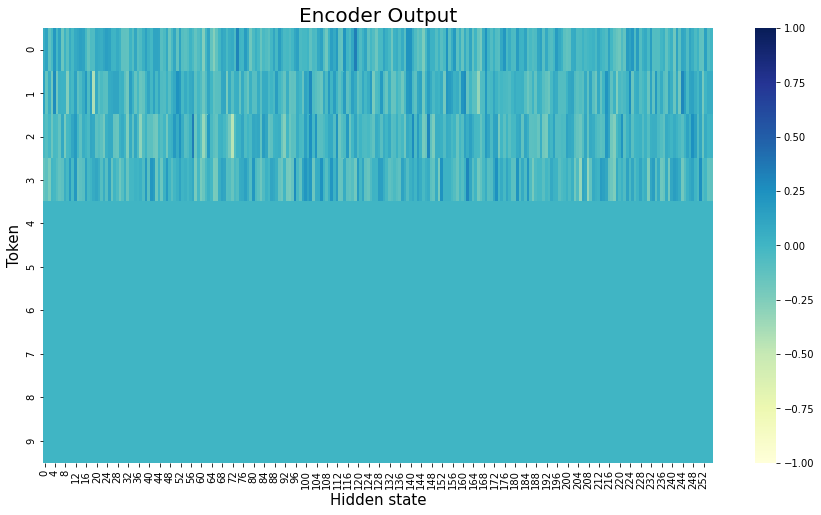

In [46]:
i = 3

print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# print(encoder_outputs.shape, encoder_hidden.shape)
# View of Encoder Ouput
plot_matrix(encoder_outputs)

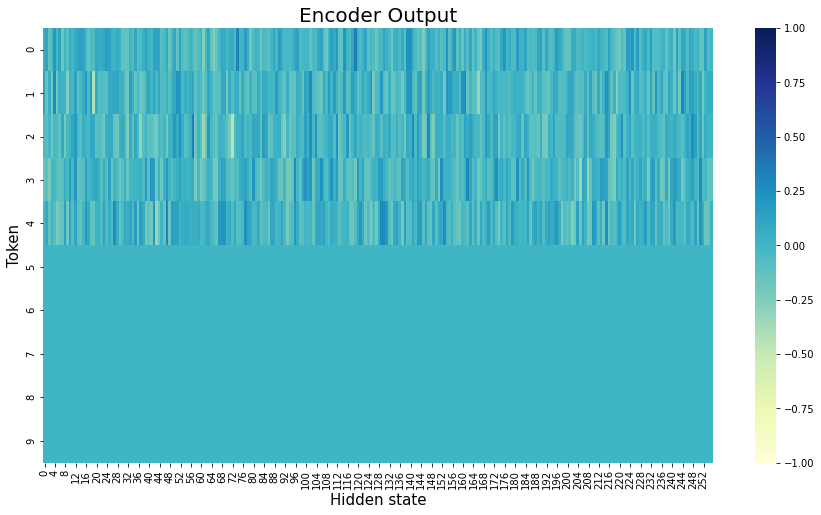

In [47]:
i = 4

# print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
# input_tensor - 5th word/token is taken from input sentence. It is then reshaped to add batch dimension and passed to the embedding layer.
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# print(encoder_outputs.shape, encoder_hidden.shape)
# View of Encoder Ouput
plot_matrix(encoder_outputs)

When 'EOS' is passed to the encoder:


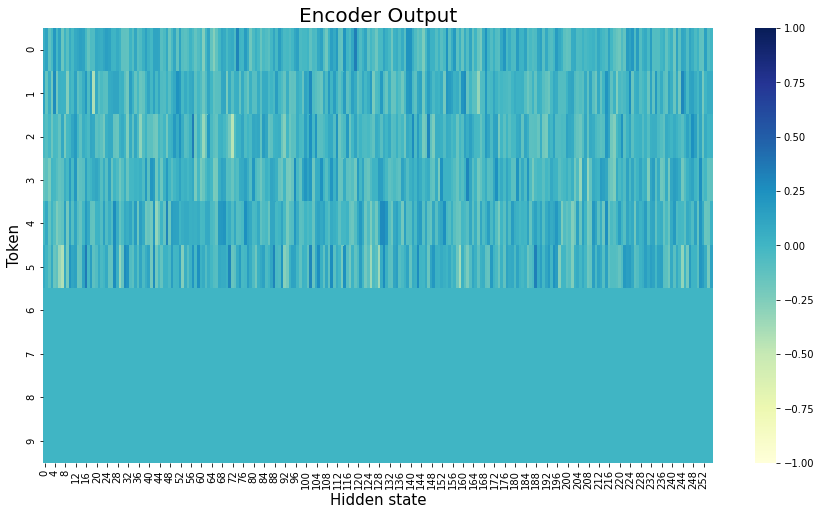

In [48]:
i = 5

print(f"When '{input_lang.index2word[input_tensor[i].item()]}' is passed to the encoder:")
embedded_input = embedding(input_tensor[i].view(-1, 1))
# print(embedded_input.shape)
output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
encoder_outputs[i] += output[0,0]
# print(encoder_outputs.shape, encoder_hidden.shape)
# View of Encoder Ouput
plot_matrix(encoder_outputs)

In [ ]:
# encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
# encoder_hidden = torch.zeros(1, 1, 256, device=device)
# encoder_cell_state = torch.zeros(1, 1, 256, device=device)

# for i in range(input_tensor.size()[0]):
#   embedded_input = embedding(input_tensor[i].view(-1, 1))
#   output, (encoder_hidden, encoder_cell_state) = lstm(embedded_input, (encoder_hidden, encoder_cell_state))
#   encoder_outputs[i] += output[0,0]

# Decoder

In [169]:
import torch.nn.functional as F

In [170]:
# first input
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
decoder_hidden = encoder_hidden
decoded_words = []
output_size = output_lang.n_words
num_layers = 1

In [171]:
embedding = nn.Embedding(output_size, 256).to(device)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
dec_lstm = nn.LSTM(256, 256, num_layers, bias=False).to(device)
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)

In [172]:
pred_op = []

#### Decoder Model Trainig with 50% probability Teacher Forcing
---

In [173]:
import matplotlib.ticker as ticker
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(22,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.title('Attention Map', fontsize = 20) # title with fontsize 20
    plt.xlabel('Input Tokens', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Predicted Tokens', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [174]:
import numpy as np
teacher_forcing = 0.5

Target: they 
Predicted: french
Attention Map


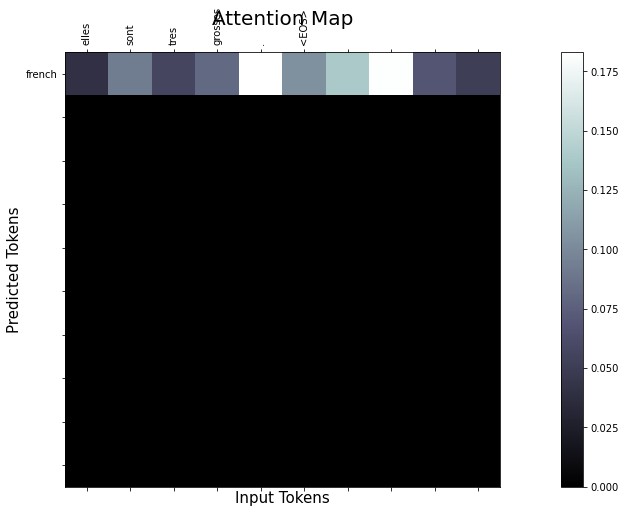

In [175]:
i = 0

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else SOS_token]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: {target_sentence.split(' ')[i]} \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

Target: are 
Predicted: impossible
Attention Map


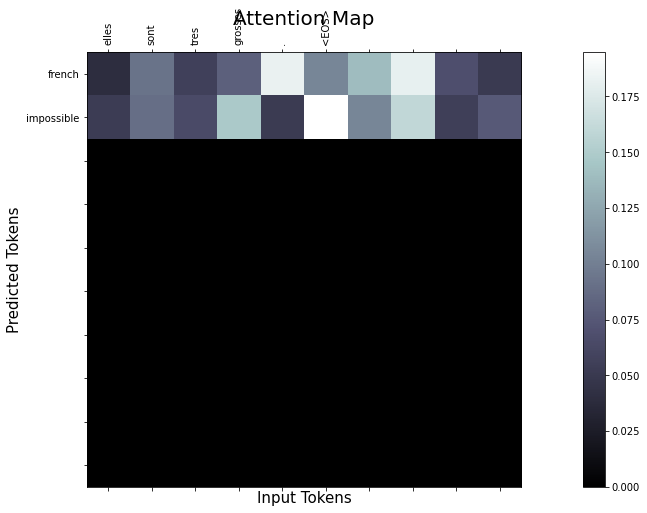

In [176]:
i = 1

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else pred_op[i-1]]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: {target_sentence.split(' ')[i]} \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

Target: very 
Predicted: foolish
Attention Map


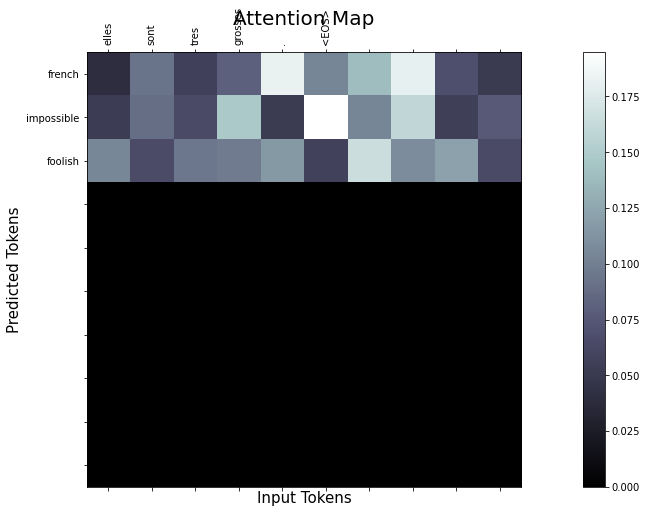

In [177]:
i = 2

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else pred_op[i-1]]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: {target_sentence.split(' ')[i]} \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

Target: big 
Predicted: foolish
Attention Map


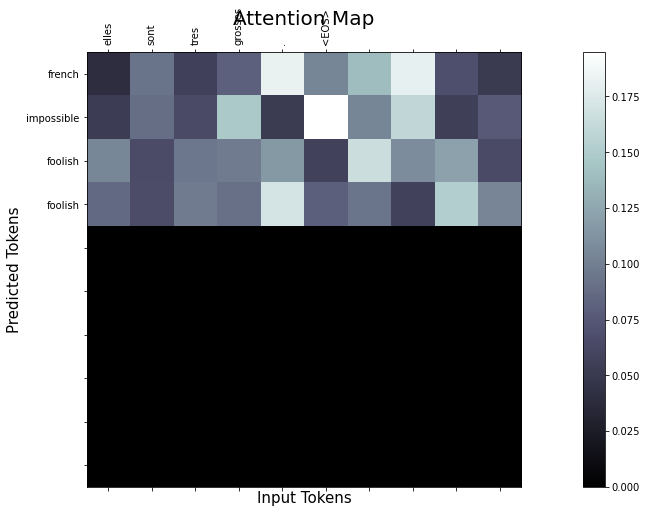

In [178]:
i = 3

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else pred_op[i-1]]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: {target_sentence.split(' ')[i]} \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

Target: . 
Predicted: foolish
Attention Map


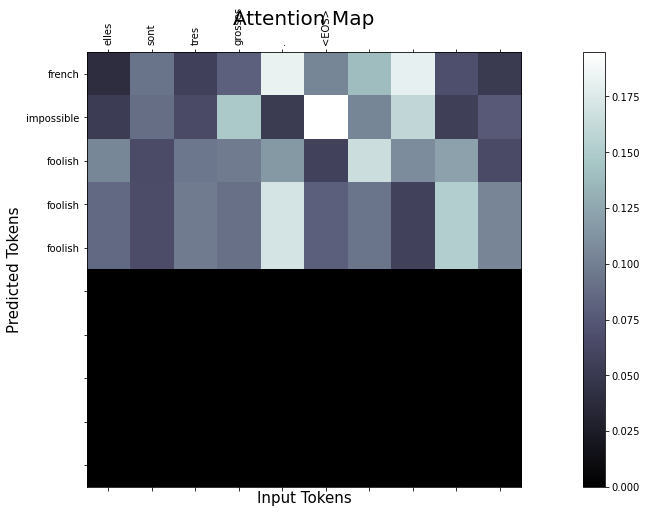

In [179]:
i = 4

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else pred_op[i-1]]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: {target_sentence.split(' ')[i]} \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

Target: <EOS> 
Predicted: handkerchiefs
Attention Map


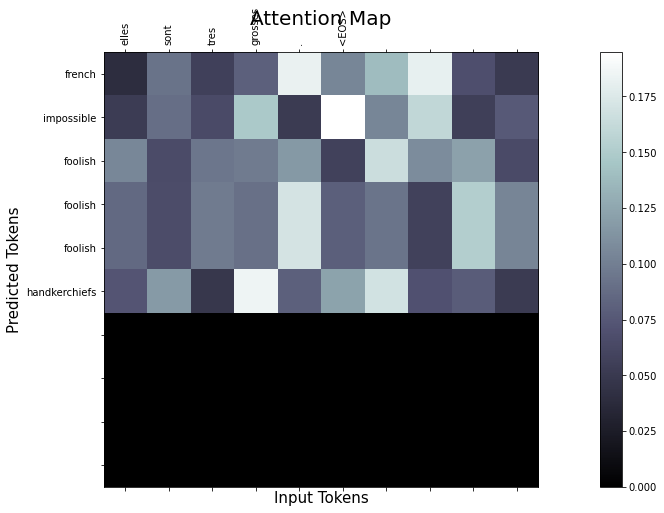

In [180]:
i = 5

decoder_input = torch.tensor([[target_indices[i] if np.random.binomial(1,teacher_forcing) == 1 else pred_op[i-1]]], device=device)
decoder_hidden = encoder_hidden
decoder_cell_state = encoder_cell_state

embedded = embedding(decoder_input)

attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)

output, (decoder_hidden, decoder_cell_state) = dec_lstm(input_to_lstm, (decoder_hidden, decoder_cell_state))

output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)

top_value, top_index = output.data.topk(1)
pred_op.append(top_index.item())
decoder_attentions[i] = attn_weights.data.detach().cpu()
print(f"Target: <EOS> \nPredicted: {output_lang.index2word[top_index.item()]}")#, attn_weights)
print("Attention Map")
showAttention(input_sentence, [output_lang.index2word[pred] for pred in pred_op], decoder_attentions)

In [181]:
print(f"Target Sentence: {target_sentence}")
print(f"Predicted Sentence: {' '.join([output_lang.index2word[pred] for pred in pred_op])}")

Target Sentence: they are very big .
Predicted Sentence: french impossible foolish foolish foolish handkerchiefs


In [ ]:
# for i in range(6):
#   decoder_input = torch.tensor([[target_indices[i]]], device=device)
#   decoder_hidden = encoder_hidden
#   output_size = output_lang.n_words
#   embedded = embedding(decoder_input)
#   attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
#   attn_weights = F.softmax(attn_weights, dim = 1)
#   attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
#   input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
#   input_to_lstm = input_to_lstm.unsqueeze(0)
#   output, decoder_hidden = dec_lstm(input_to_lstm, decoder_hidden)
#   output = F.relu(output)
#   output = F.softmax(output_word_layer(output[0]), dim = 1)
#   top_value, top_index = output.data.topk(1)
#   print(target_sentence.split(" ")[i], target_indices[i], output_lang.index2word[top_index.item()], top_index.item() )
#   print(attn_weights)

she 75 protection 2639
tensor([[0.1963, 0.0714, 0.1112, 0.0420, 0.0733, 0.1459, 0.1215, 0.0684, 0.0777,
         0.0922]], device='cuda:0', grad_fn=<SoftmaxBackward>)
is 40 mayor 2181
tensor([[0.1561, 0.0784, 0.0958, 0.0917, 0.0955, 0.0800, 0.0365, 0.0860, 0.0786,
         0.2014]], device='cuda:0', grad_fn=<SoftmaxBackward>)
much 1712 interruption 2581
tensor([[0.1080, 0.1755, 0.1255, 0.0996, 0.1081, 0.0918, 0.0397, 0.0481, 0.1262,
         0.0776]], device='cuda:0', grad_fn=<SoftmaxBackward>)
taller 150 reconsider 2030
tensor([[0.1384, 0.2128, 0.1743, 0.0535, 0.0496, 0.0640, 0.0506, 0.0581, 0.1342,
         0.0644]], device='cuda:0', grad_fn=<SoftmaxBackward>)
than 1166 apparently 2570
tensor([[0.0549, 0.1845, 0.1235, 0.1107, 0.0398, 0.1449, 0.0693, 0.0782, 0.1197,
         0.0745]], device='cuda:0', grad_fn=<SoftmaxBackward>)
me 343 parasol 2750
tensor([[0.0365, 0.1068, 0.0979, 0.1026, 0.0858, 0.1254, 0.0327, 0.1611, 0.0836,
         0.1677]], device='cuda:0', grad_fn=<SoftmaxBackwa

In [182]:
target_indices, target_sentence, input_sentence

([221, 124, 303, 131, 4, 1],
 'they are very big .',
 'elles sont tres grosses .')

# Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![image](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![image](https://pytorch.org/tutorials/_images/attention-decoder-network.png)



